This program requests data from the Swarm API for a specified spacecraft and time range. The data is then plotted in a grid of subplots, with each subplot showing the data for a single orbit. The program can plot the data in three different ways:

- Using two different colors to distinguish between Ti(meas_drift) and Ti(model_drift).   
- Using two different colors to distinguish between low-gain and high-gain measurements.   
- Using two different colors to distinguish between Tii-based and corrected temperature measurements.     

The following constants can be modified to customize the behavior of the program:    
 
`SPACECRAFT`: Spacecraft options which user can change manually. Available 3 options "A", "B", "C".    
`TIME`: Time for which to request data. This should be in ISO format (e.g. "2016-01-02T00:00:00Z").   
`FIGURE_OPTIONS`: Dictionary of options for creating the plot figure. This dictionary is passed as keyword arguments to the [matplotlib.pyplot.figure](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html) function.
- *figsize* determines the size of the figure in inches. The figure width is given by the first element of the tuple, and the figure height is given by the second element.
- *dpi (dots per inch)* determines the resolution of the figure in dots per inch. A higher value will result in a higher-resolution figure.

In [2]:
SPACECRAFT = "B" # A B C 
TIME = "2016-01-02T00:00:00Z"
FIGURE_OPTIONS = {
    "figsize": (20, 15),
    "dpi": 150,
}

In [3]:
from viresclient import SwarmRequest
SERVER_URL = "https://vires.services/ows"
collection = f"SW_OPER_EFI{SPACECRAFT}TIE_2_"
request = SwarmRequest(SERVER_URL)

orbit_number = request.get_orbit_number(SPACECRAFT, TIME)
start_time, end_time = request.get_times_for_orbits(orbit_number, orbit_number + 3, spacecraft=SPACECRAFT)

In [4]:
def request_data(url, collection, start_time, end_time):
    """
    Make a request for data from the Swarm API.
    """
    request = SwarmRequest(url)
    request.set_collection(collection)    
    request.set_products(
        measurements=SwarmRequest.PRODUCT_VARIABLES["EFI_TIE"], # request all dataset variables
        auxiliaries=['QDLat', 'QDLon', 'MLT', 'OrbitNumber', 'OrbitDirection'], # QD coordinates and MLT calculated by VirES
    )
    data = request.get_between(
        start_time=start_time,
        end_time=end_time,
    ).as_xarray()
    return data

In [5]:
import matplotlib.pyplot as plt
import numpy as np

data = request_data(SERVER_URL, collection, start_time, end_time)
orbit_numbers = np.unique(data['OrbitNumber'].values)
ncols = 2
nrows = orbit_numbers.size

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (6.564MB)

In [6]:
def plot_data1(data, mask,label):
    """
    Plot data using two different colors to distinguish between Ti(meas_drift) and Ti(model_drift).
    """
    times = data["Timestamp"][mask].values.astype("datetime64[s]")
    h_meas = plt.plot(data["Latitude"][mask], data["Ti_meas_drift"][mask],'.r',ms=1)
    h_model = plt.plot(data["Latitude"][mask], data["Ti_model_drift"][mask], '.b',ms=1) 
    plt.title(f"{times.min()} / {times.max()} {label}")
    plt.xlim(data["Latitude"].min(), data["Latitude"].max())
    plt.legend([h_meas[0],h_model[0]], ["Ti(model_drift)","Ti(meas_drift)" ])


def plot_data2(data, mask, label, show_legend=True):
    """
    Plot data using two different colors to distinguish between low-gain and high-gain measurements.
    """
    mask_lp_mode = data['Flag_ti_meas'][mask] & 2 == 2
    h1 = plt.plot(data["Latitude"][mask][mask_lp_mode], data["Ti_meas_drift"][mask][mask_lp_mode], '.b', ms = 1)
    h2 = plt.plot(data["Latitude"][mask][~mask_lp_mode], data["Ti_meas_drift"][mask][~mask_lp_mode], '.r', ms = 1)
    plt.title(label)
    if show_legend:
        plt.legend([h1[0], h2[0]],['Low-gain', 'High-gain'])
    plt.xlim(data["Latitude"].min(), data["Latitude"].max())


def plot_data3(data, mask, label):
    """
    Plot data using two different colors to distinguish between Tii-based and corrected temperature measurements.
    """
    tii_based = plt.plot(data["Latitude"][mask], data["Ti_meas_drift"][mask], ".r", ms = 1)
    corrected_temp = plt.plot(data["Latitude"][mask], data["Te_adj_LP"][mask] ,".", color = "purple", ms = 1)
    normalised_temp = plt.plot(data["Latitude"][mask], data["Tn_msis"][mask], ".g", ms = 1)
    plt.title(label)
    plt.legend([tii_based[0], corrected_temp[0], normalised_temp[0]],['Ti', 'Te(corrected)', 'Tn(NRLMSISE00)'])
    plt.xlim(data["Latitude"].min(), data["Latitude"].max())


def plot_figure(plot_data):
    """
    Plot data for each orbit in a grid of subplots.
    """
    fig = plt.figure(**FIGURE_OPTIONS)

    for idx, orbit_number in enumerate(orbit_numbers):
        plt.subplot(nrows, ncols, idx*2 + 1)
        plt.grid()
        plt.ylabel("Temperature, K", fontsize = 10)
        mask_asc  = (data['OrbitNumber'].values == orbit_number) & (data['OrbitDirection'].values == 1)
        plot_data(data, mask_asc, f"ascending orbit #{orbit_number} ")
        plt.subplot(nrows, ncols, idx*2 + 2)
        plt.grid()
        plt.ylabel("Temperature, K", fontsize = 10)
        mask_dsc  = (data['OrbitNumber'].values == orbit_number) & (data['OrbitDirection'].values == -1)
        plot_data(data,mask_dsc, f"descending orbit #{orbit_number}")
        fig.tight_layout()

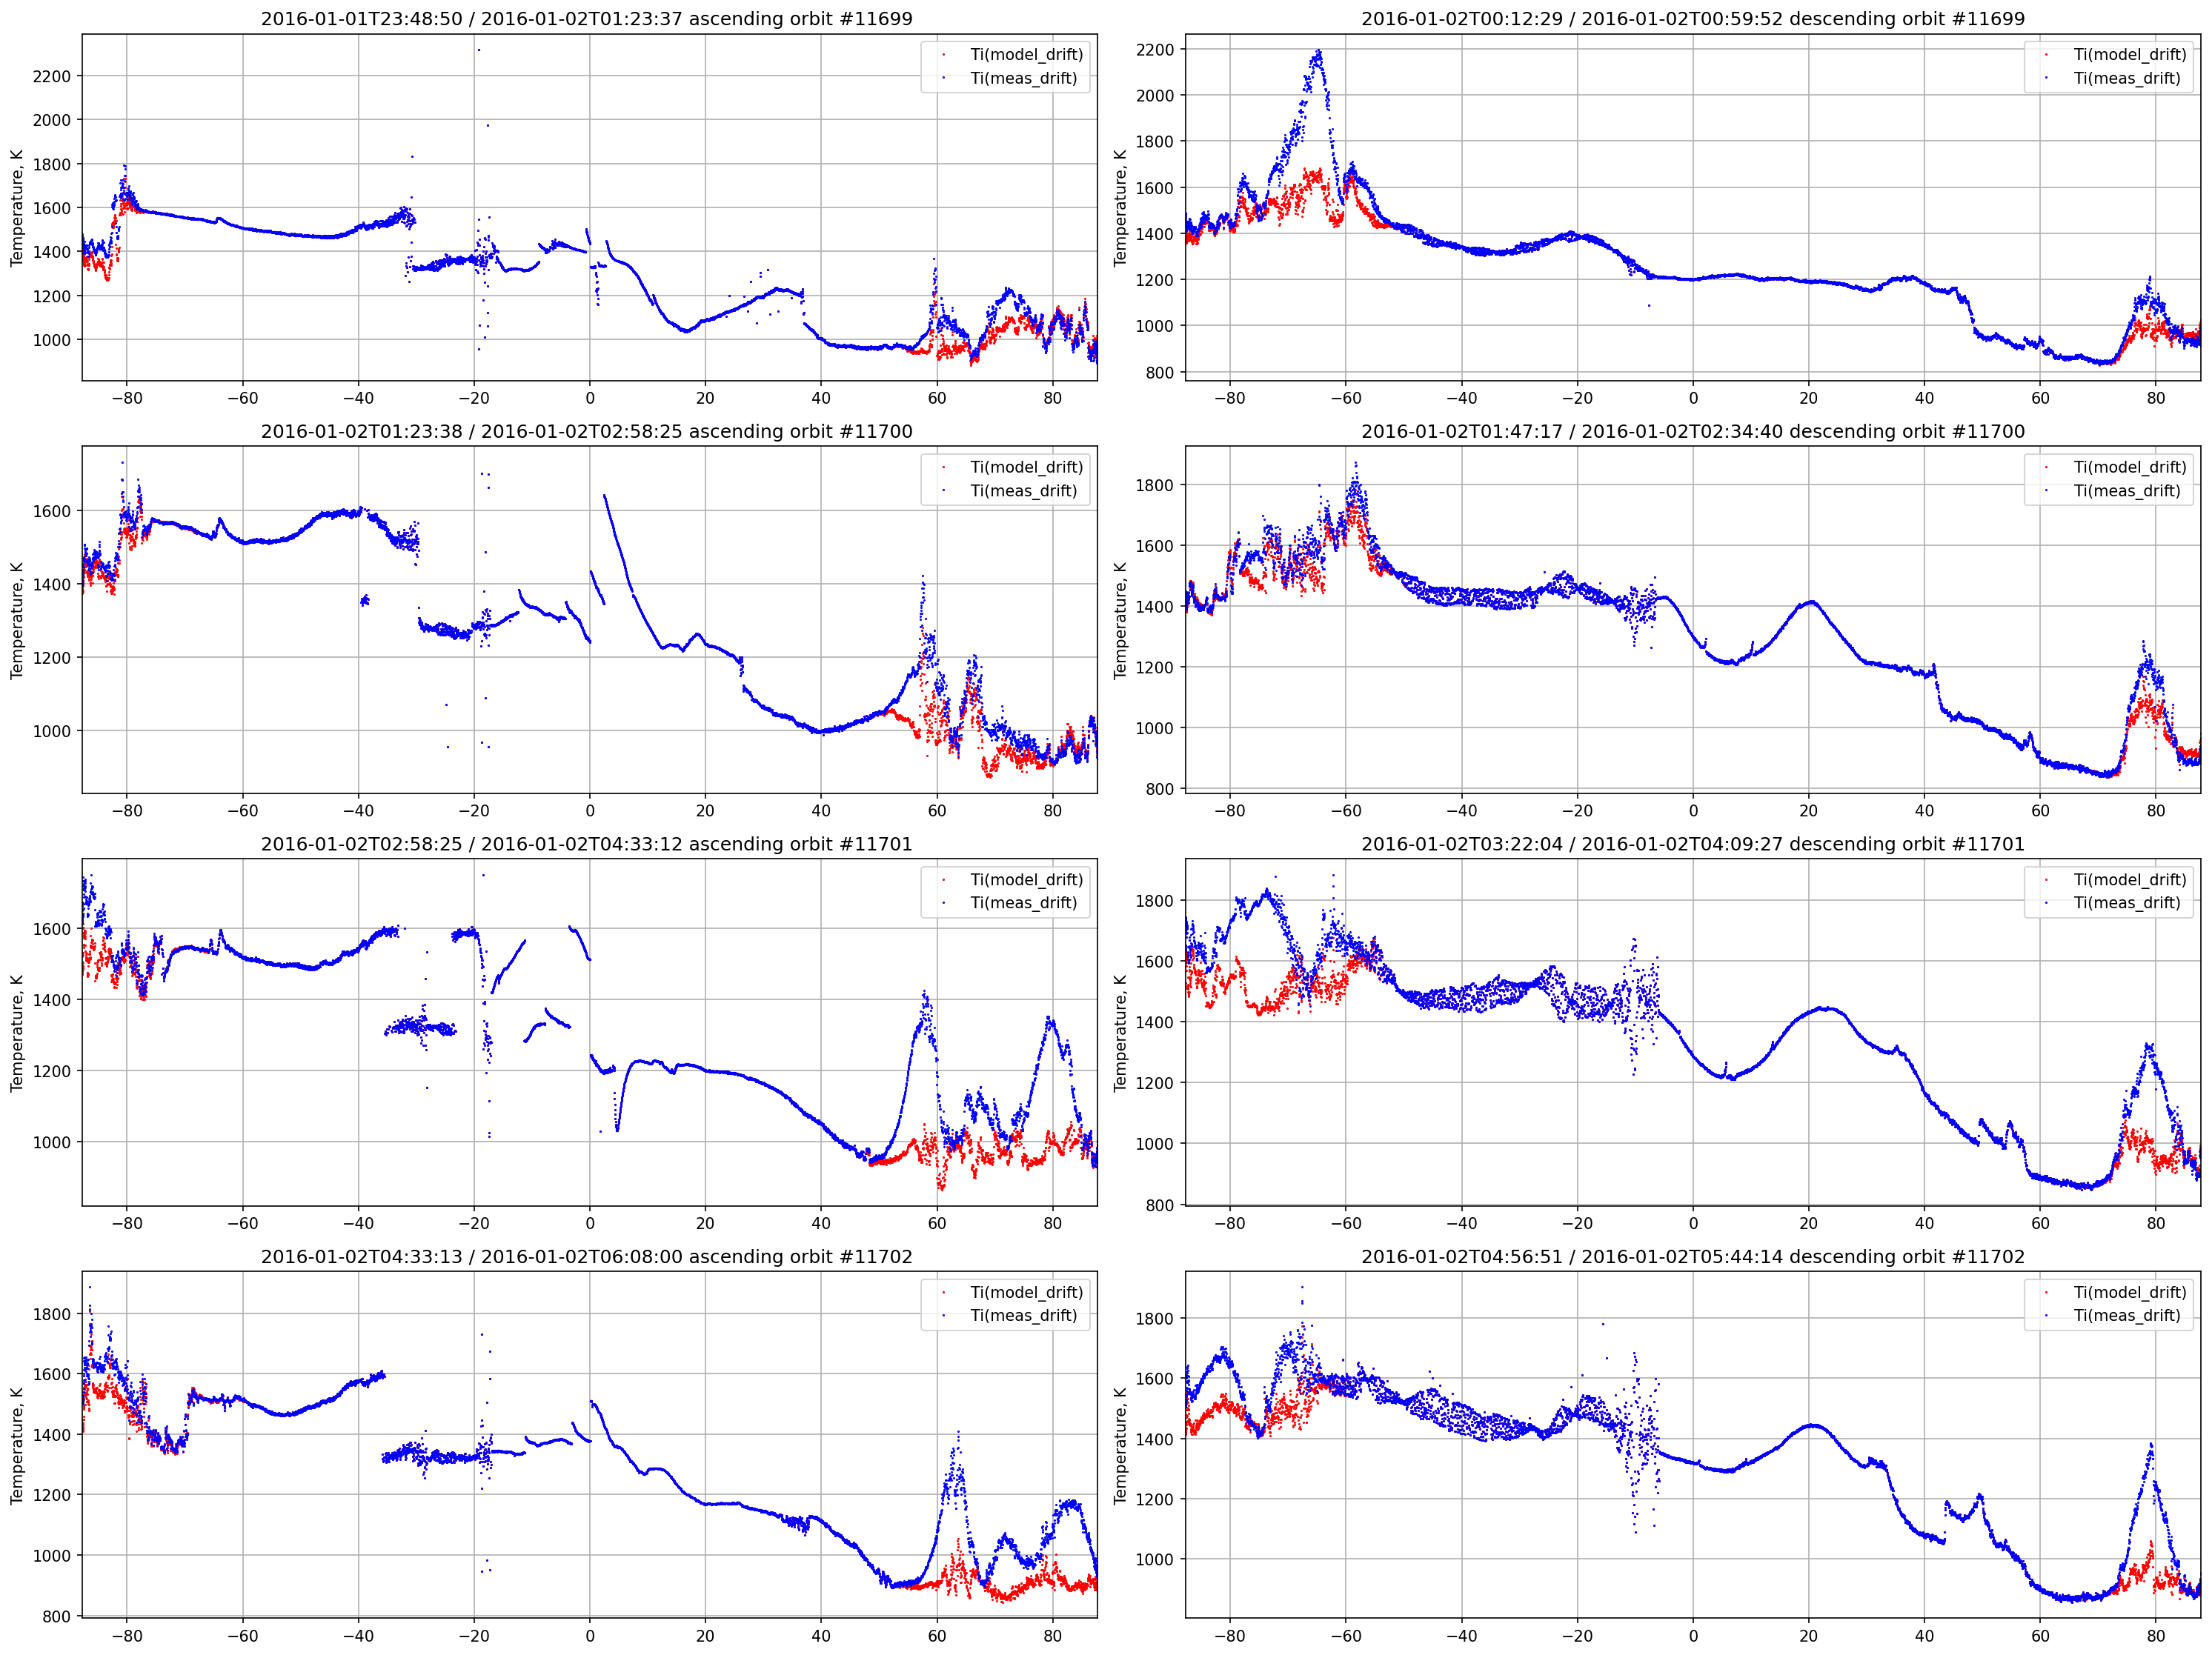

In [7]:
plot_figure(plot_data1)

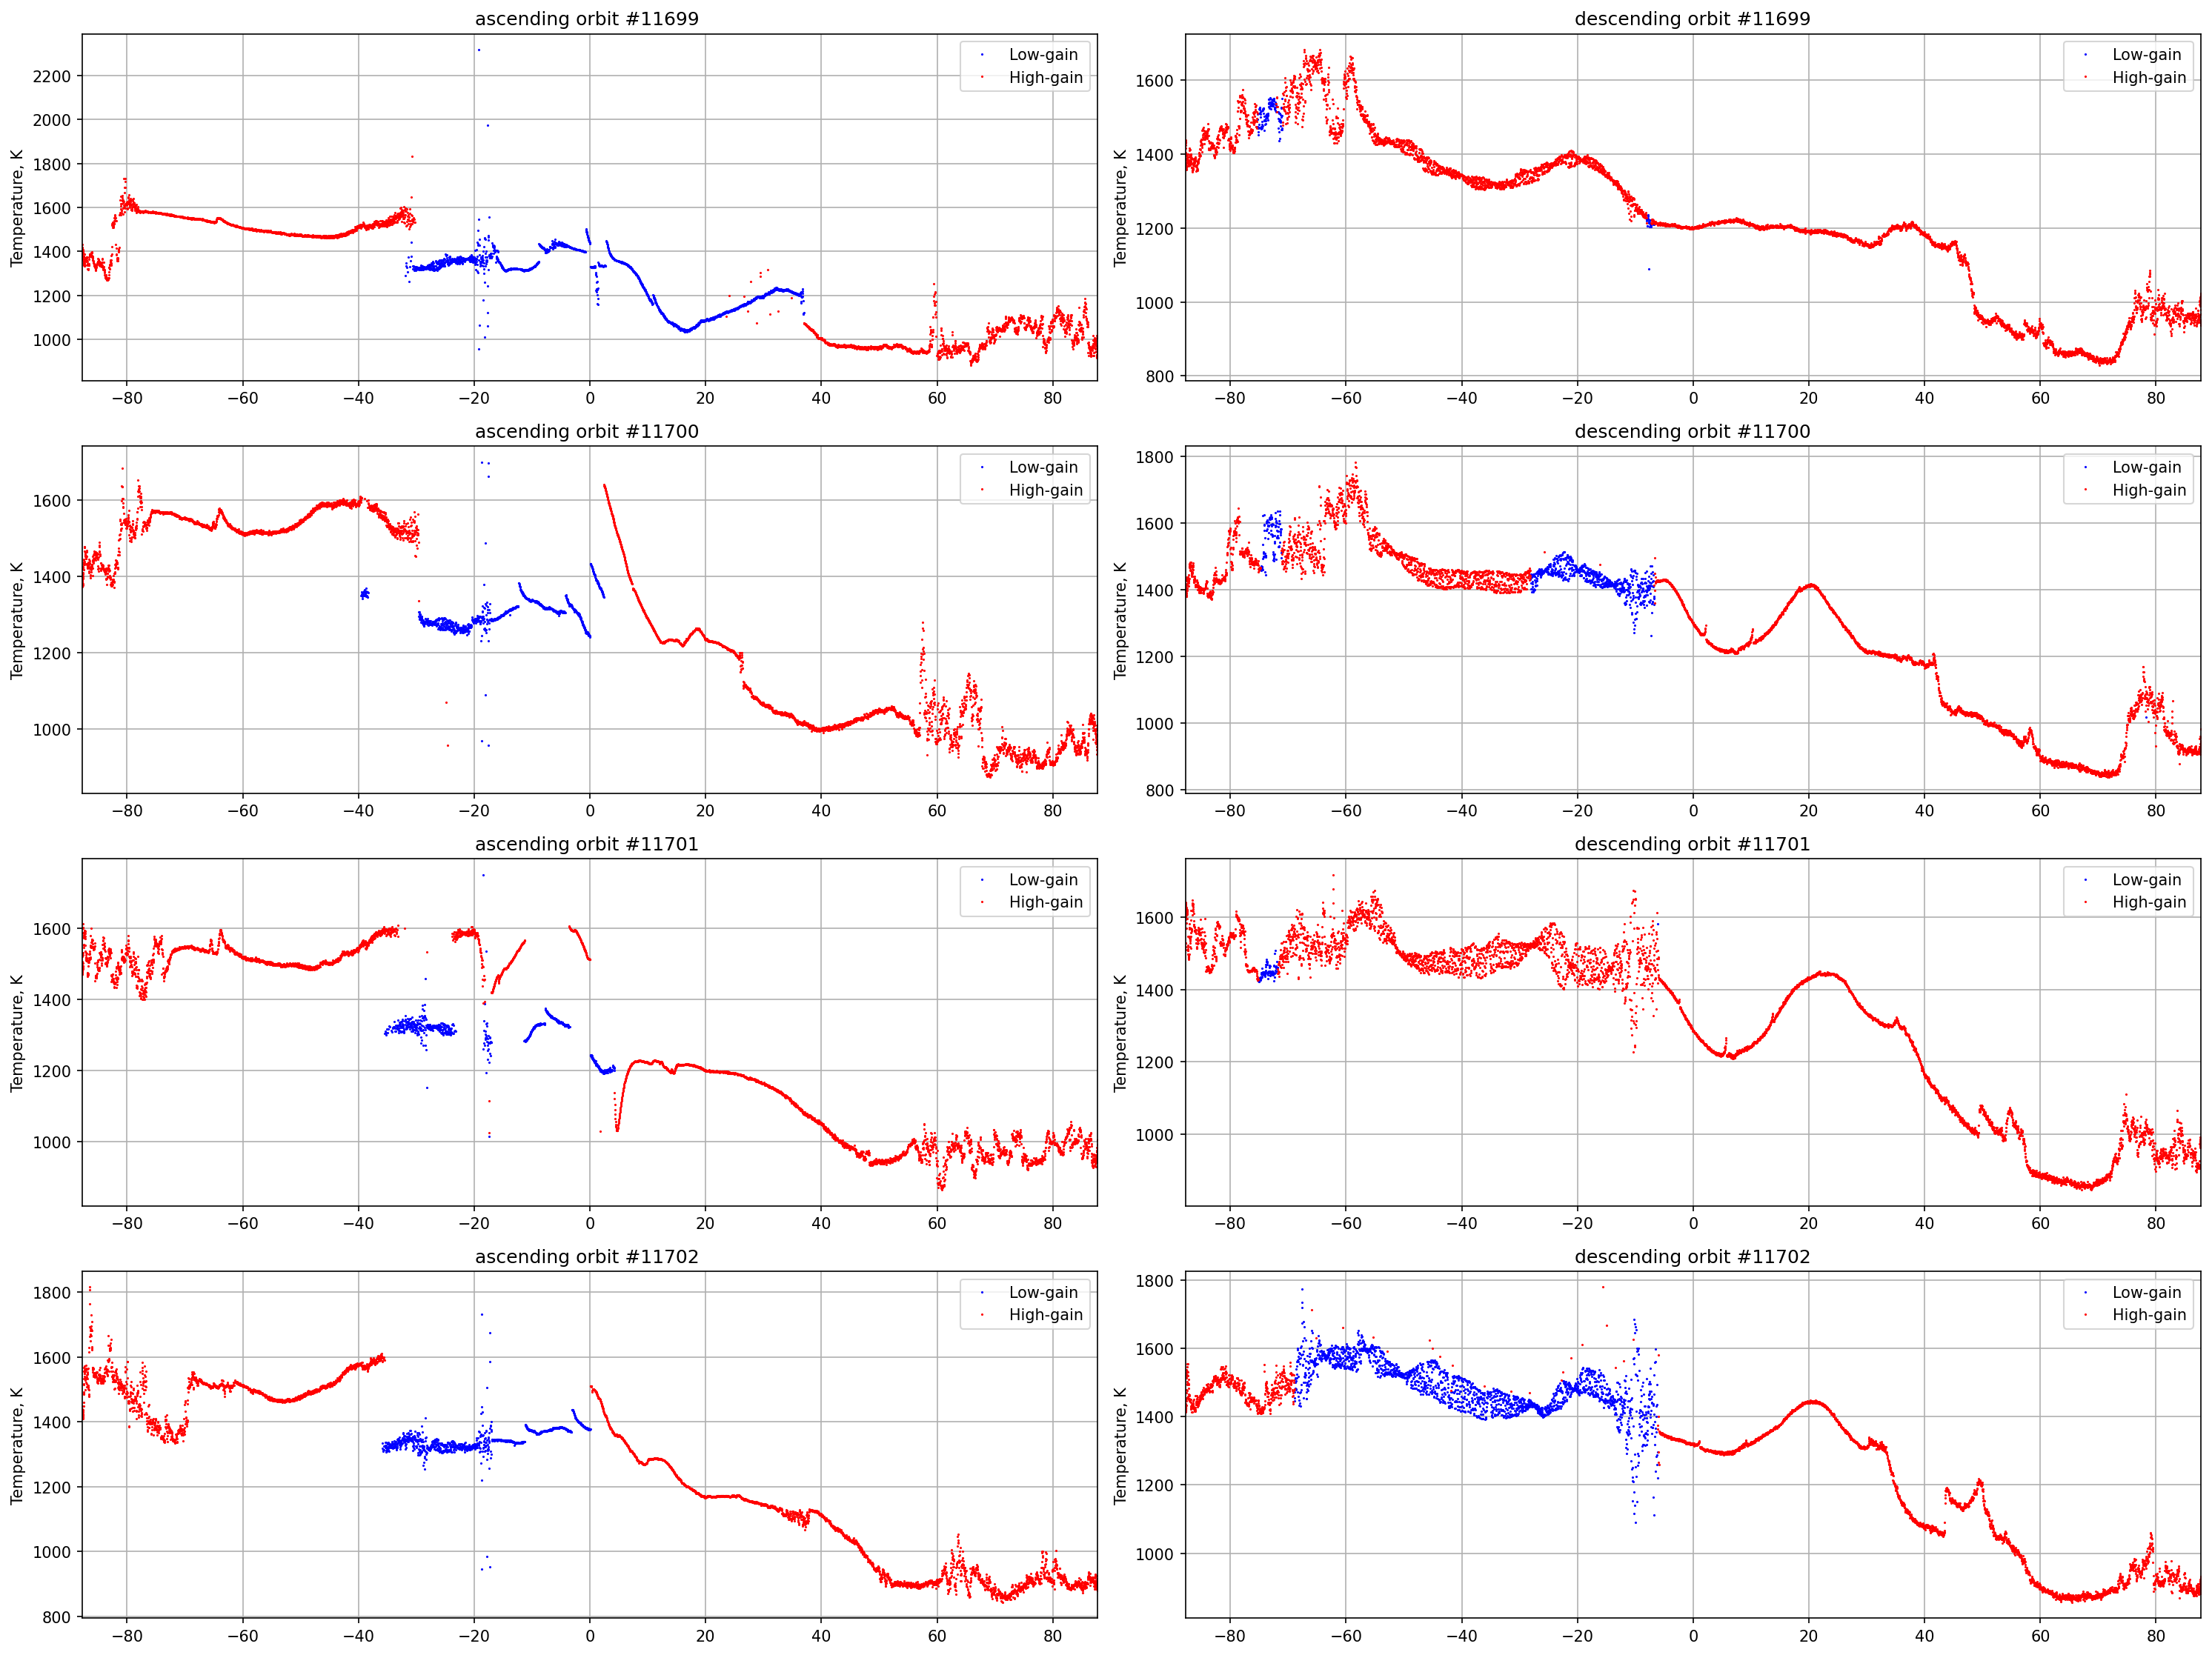

In [8]:
plot_figure(plot_data2)

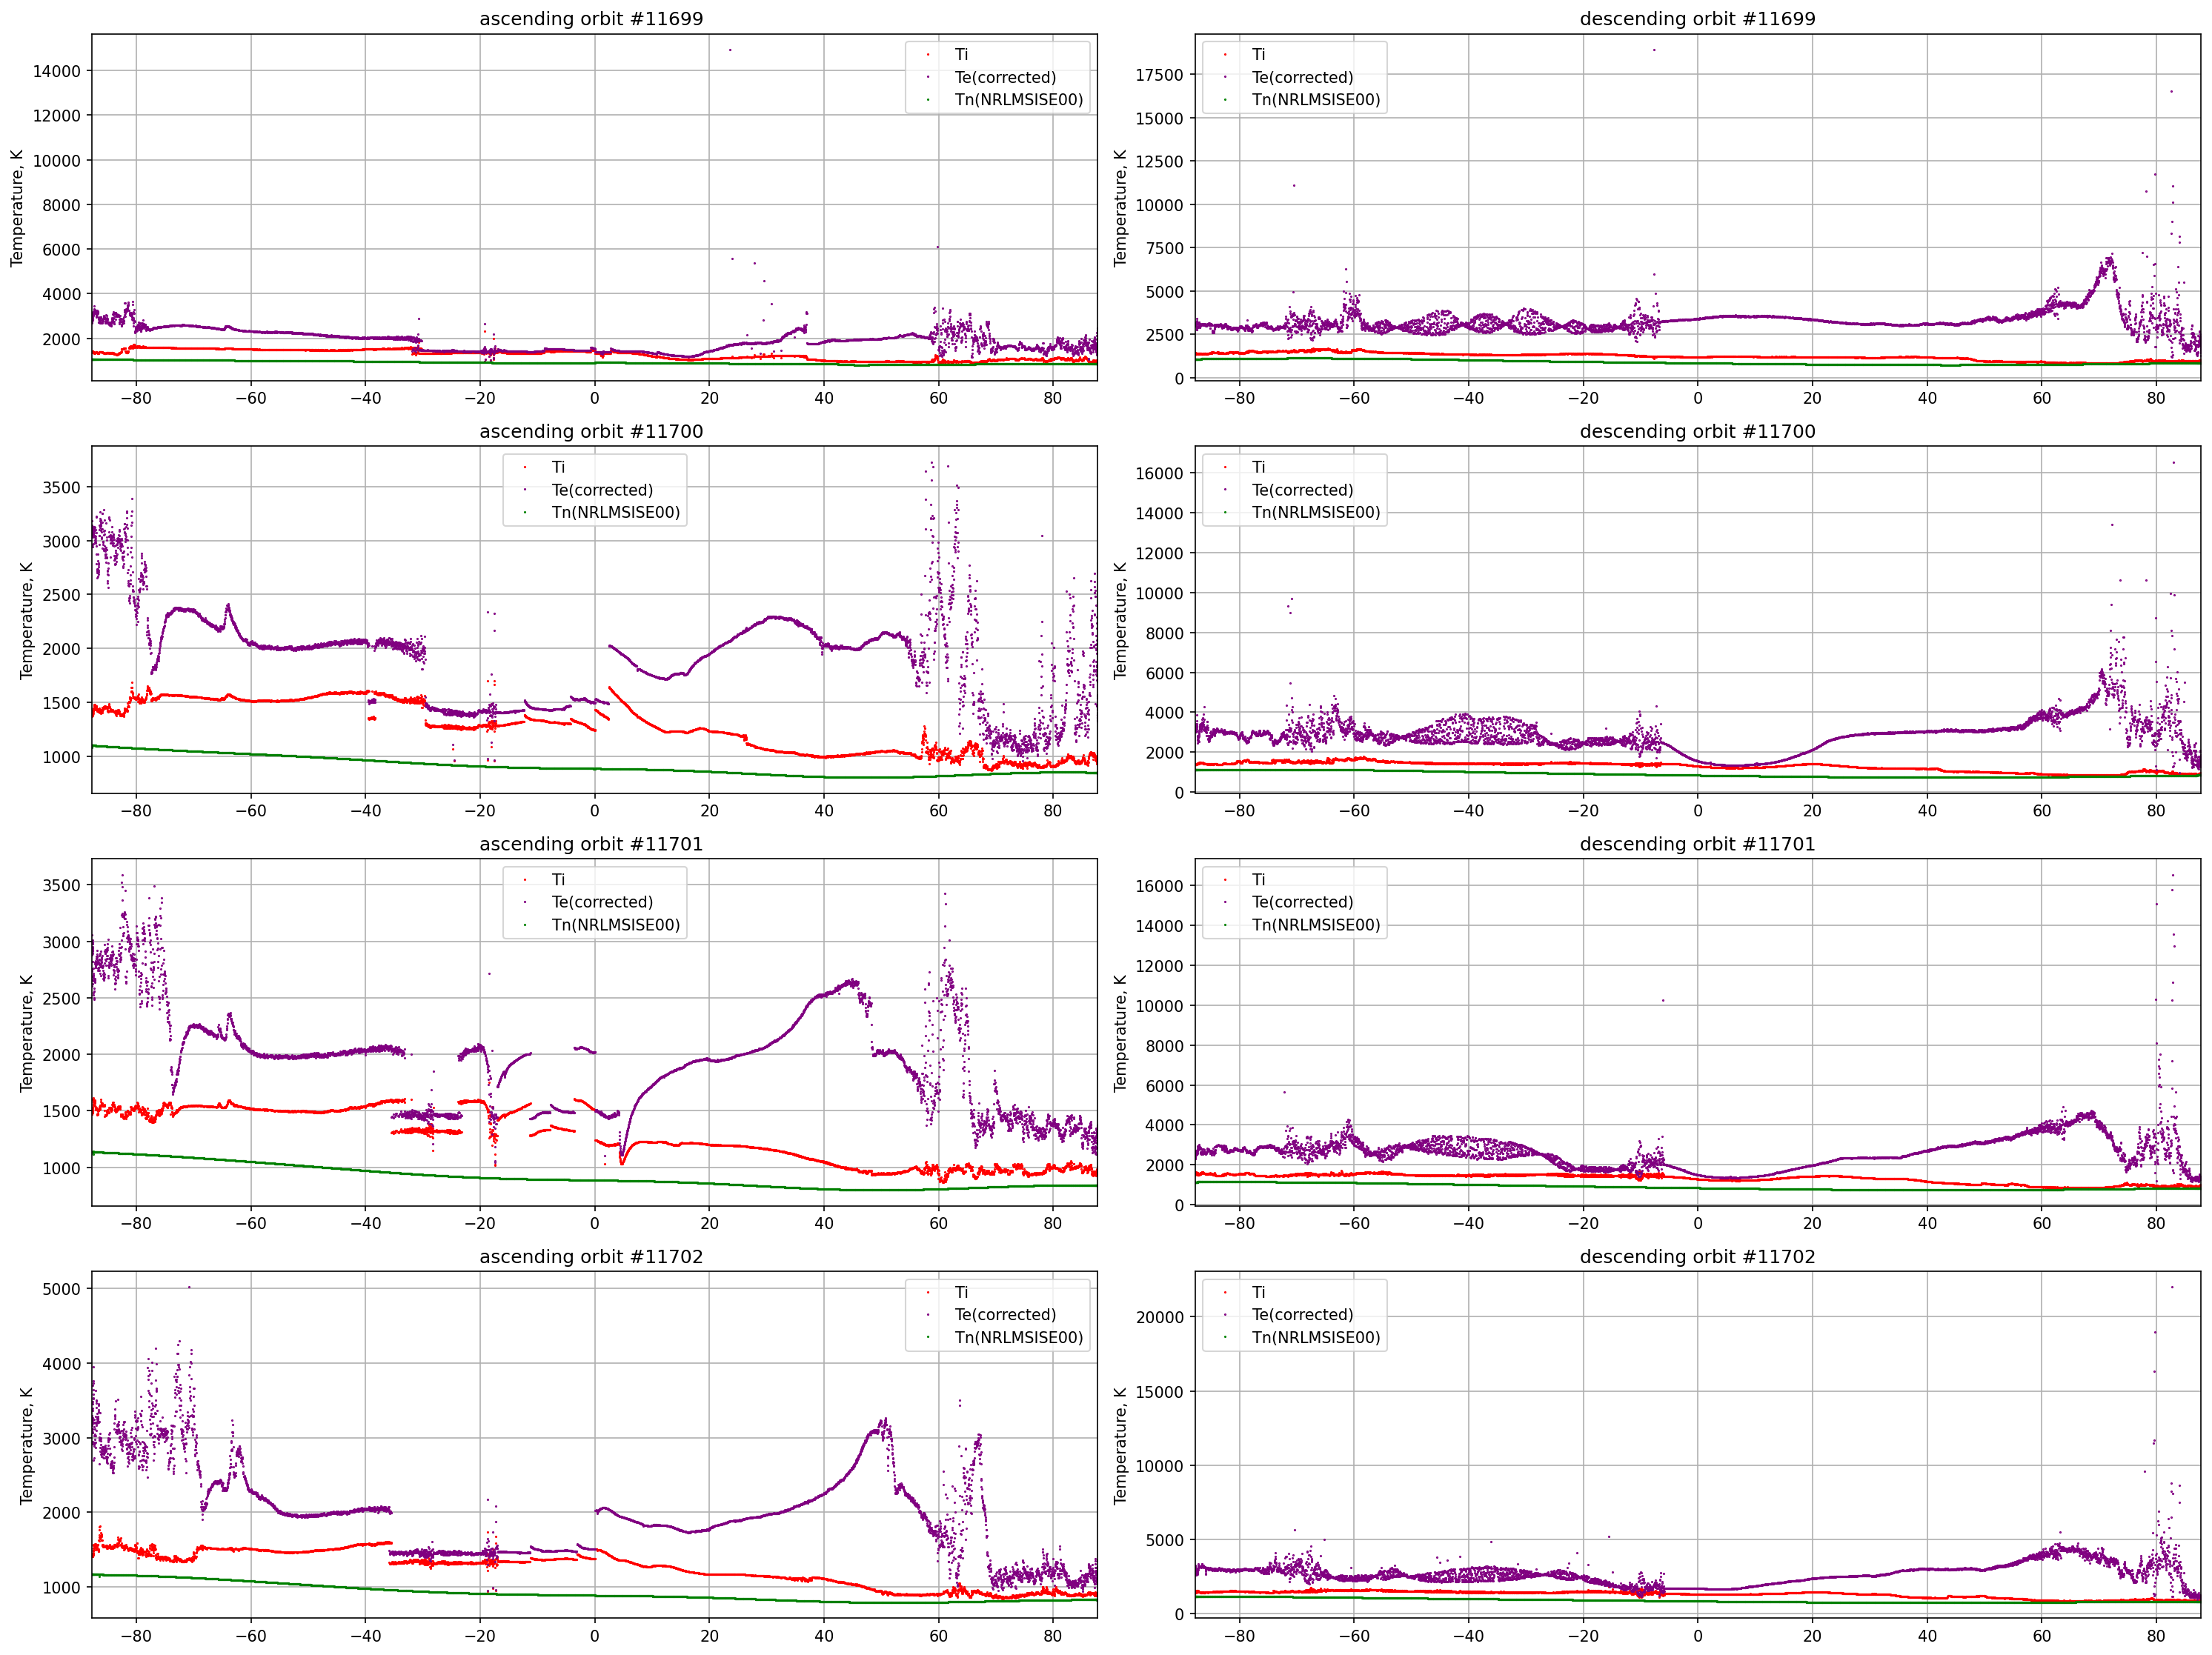

In [9]:
plot_figure(plot_data3)